In [50]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [77]:
df = pd.read_excel("data/Project 2_2022.xlsx")
df.Date = pd.to_datetime(df.Date)
df['weekday'] = df.Date.dt.weekday
df["is_holiday"] = df.apply(lambda x: x['weekday'] == 5 or x['weekday'] == 6 or x.Date in holidays.country_holidays('RU'), axis=1)

In [78]:
df

,Date,Income,Outcome,Balance,weekday,is_holiday
0,2017-01-09,1.343028,1.487865,-0.155904,0,False
1,2017-01-10,1.068610,1.194182,-0.125572,1,False
2,2017-01-11,0.944429,0.936663,0.007767,2,False
3,2017-01-12,1.672202,0.875379,0.800391,3,False
4,2017-01-13,0.955924,0.975645,-0.019721,4,False
...,...,...,...,...,...,...
1538,2021-03-27,0.000000,0.000000,0.000000,5,True
1539,2021-03-28,0.000000,0.000000,0.000000,6,True
1540,2021-03-29,2.356883,3.370738,-1.017679,0,False
1541,2021-03-30,2.317382,2.567554,-0.259687,1,False


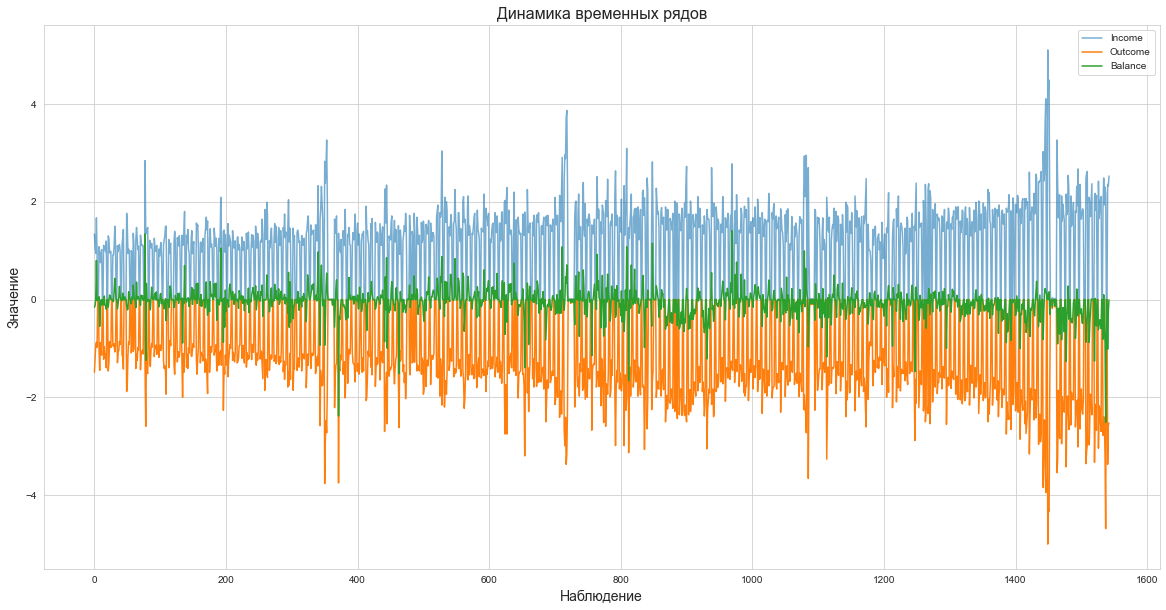

In [84]:
plt.figure(figsize=(20,10))
plt.title('Динамика временных рядов', fontsize=16)
plt.xlabel('Наблюдение', fontsize=14)
plt.ylabel('Значение', fontsize=14)
# plt.xticks(df.Date)
df.Income.plot(alpha=0.6)
(-df.Outcome).plot()
df.Balance.plot()
plt.legend()
plt.show()

In [86]:
# Импортируем все необходимые нам в работе инструменты

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from arch.unitroot import PhillipsPerron
from scipy import stats
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# SARIMA TIME!

In [85]:
import arch.unitroot as ur

In [96]:
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# применяем к ряду тест adf
adf_test(df['Balance'].diff().fillna(0))

Results of Dickey-Fuller Test:
Test Statistic                -1.477228e+01
p-value                        2.312580e-27
#Lags Used                     1.900000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
dtype: float64


In [97]:
# применяем к ряду тест adf
adf_test(df[df['is_holiday'] == False].Balance.diff().fillna(0))

Results of Dickey-Fuller Test:
Test Statistic                -1.230422e+01
p-value                        7.333464e-23
#Lags Used                     1.800000e+01
Number of Observations Used    1.037000e+03
Critical Value (1%)           -3.436672e+00
Critical Value (5%)           -2.864331e+00
Critical Value (10%)          -2.568256e+00
dtype: float64


In [98]:
pp = PhillipsPerron(df[df['is_holiday'] == False].Balance.diff().fillna(0))
print(pp.summary().as_text());

     Phillips-Perron Test (Z-tau)    
Test Statistic               -144.486
P-value                         0.000
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [99]:
pp = PhillipsPerron(df.Balance.diff().fillna(0))
print(pp.summary().as_text());

     Phillips-Perron Test (Z-tau)    
Test Statistic               -178.778
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [100]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df.Balance.diff().fillna(0));

KPSS Statistic: 0.045661598185854295
p-value: 0.1
num lags: 126
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/takkat14/opt/anaconda3/envs/TimeSeries/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [94]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df[df['is_holiday'] == False].Balance);

KPSS Statistic: 2.626279611743671
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/Users/takkat14/opt/anaconda3/envs/TimeSeries/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


/Users/takkat14/opt/anaconda3/envs/TimeSeries/lib/python3.10/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/takkat14/opt/anaconda3/envs/TimeSeries/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


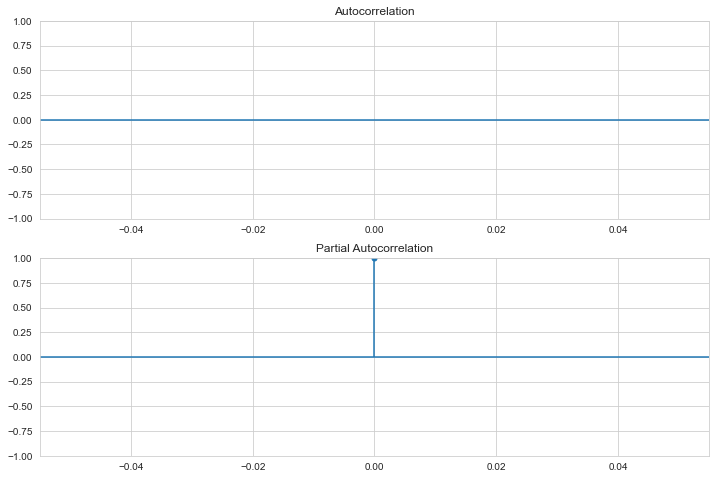

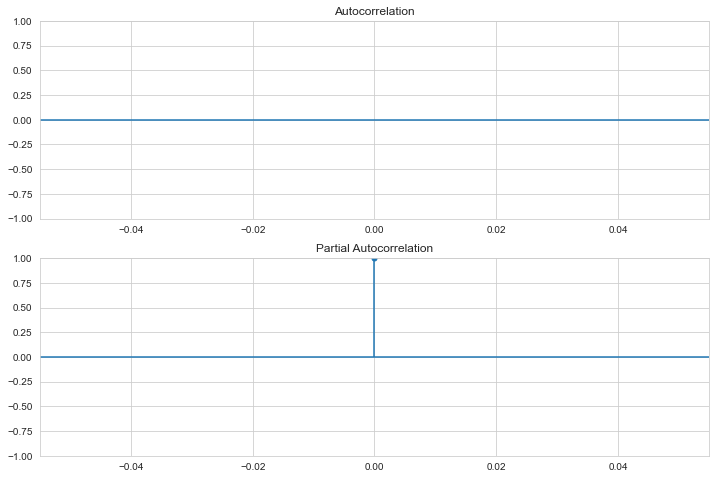

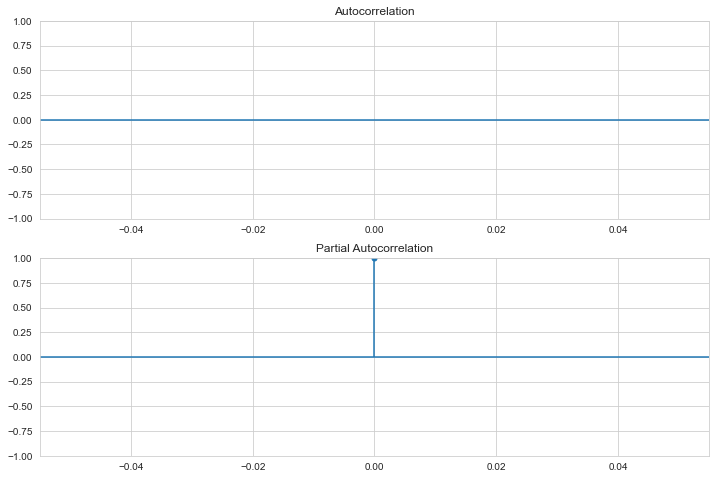

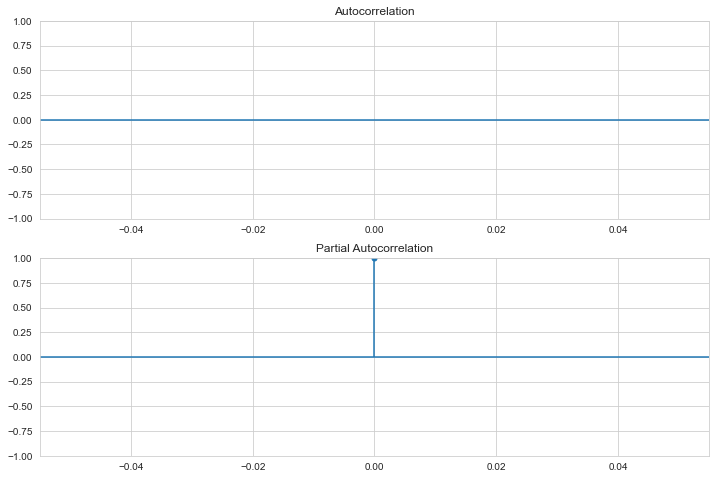

In [102]:
for lag in [10, 15, 25, 30]:
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df[df['is_holiday'] == False].Balance.diff(), lags=lag, ax=ax1) #otg1diff.values.squeeze()
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df.Balance.diff(), lags=lag, ax=ax2)
    plt.show()

In [70]:
mod = smf.ols('Diff ~ float', data=df[['Date', 'Diff']])
res = mod.fit()
print(res.summary())

beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('myreg.tex', 'w')
f.write(beginningtex)
f.write(res.summary().as_latex())
f.write(endtex)
f.close()

PatsyError: Number of rows mismatch between data argument and float (1543 versus 1)
    Diff ~ float
           ^^^^^